# Detecting COVID-19 with Chest X Ray Images using PyTorch-ResNet18

# Importing Libraries

In [135]:
%matplotlib inline

import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role

import torch
from torch.autograd import Variable

import io
from matplotlib import pyplot as plt

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.4.0


# Preparing Training and Test Sets

In [136]:
# class_names = ['normal', 'viral', 'covid']
# root_dir = 'COVID-19 Database'
# source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

# if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
#     os.mkdir(os.path.join(root_dir, 'test'))

#     for i, d in enumerate(source_dirs):
#         os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

#     for c in class_names:
#         os.mkdir(os.path.join(root_dir, 'test', c))

#     for c in class_names:
#         images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
#         selected_images = random.sample(images, 30)
#         for image in selected_images:
#             source_path = os.path.join(root_dir, c, image)
#             target_path = os.path.join(root_dir, 'test', c, image)
#             shutil.move(source_path, target_path)

# Creating Custom Dataset

In [137]:
class ChestXRayDataset_train(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['covid','normal', 'viral']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [138]:
class ChestXRayDataset_test(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [139]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [140]:
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-2


# Prepare DataLoader

In [141]:
#Set path for training directory
train_dirs = {
    'covid': 'COVID-19 Database/train/covid',
    'normal': 'COVID-19 Database/train/normal',
    'viral': 'COVID-19 Database/train/viral'
}

train_dataset = ChestXRayDataset_train(train_dirs, train_transform)

Found 100 covid examples
Found 100 normal examples
Found 100 viral examples


In [142]:
# List the input image(s) from S3 bucket
s3 = boto3.resource('s3')
bucket = s3.Bucket('covid-19-predict') 
for bucket in s3.buckets.all():
    for obj in bucket.objects.filter(Prefix='Predict/COVID-19.png'):
        print('{0}:{1}'.format(bucket.name, obj.key))

covid-19-predict:Predict/COVID-19.png


In [145]:
#Set path for test directory

test_dirs = {
   'normal': 'COVID-19 Database/test/normal',
   'viral': 'COVID-19 Database/test/viral',
   'covid': 'COVID-19 Database/test/covid'
}

test_dataset = ChestXRayDataset_train(test_dirs, test_transform)

Found 31 covid examples
Found 30 normal examples
Found 30 viral examples


In [146]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 50
Number of test batches 16


# Data Visualization

In [147]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    global D_value 
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        D_value = 'Covid Positive' # Assign value to final detection 
        if preds[i] != labels[i]:
            col = 'red'
            D_value = 'Covid Negative' # Assign value to final detection 
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

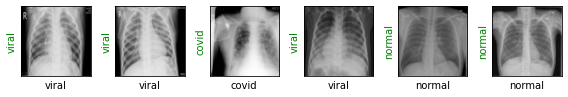

In [148]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

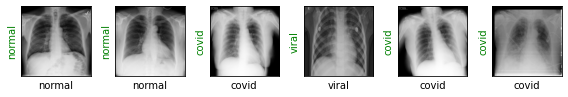

In [149]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [150]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [151]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [152]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

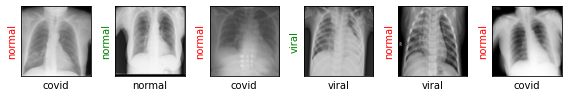

In [153]:
show_preds()

# Training the Model

In [154]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/5
Evaluating at step 0
Validation Loss: 1.3388, Accuracy: 0.3736


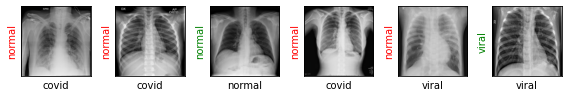

Evaluating at step 20
Validation Loss: 0.9204, Accuracy: 0.6044


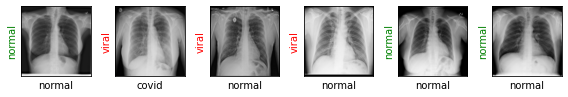

Evaluating at step 40
Validation Loss: 0.6428, Accuracy: 0.7692


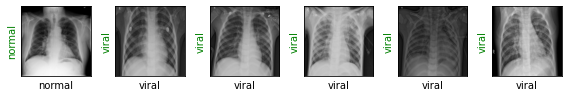

Training Loss: 0.7507
Starting epoch 2/5
Evaluating at step 0
Validation Loss: 0.4436, Accuracy: 0.8132


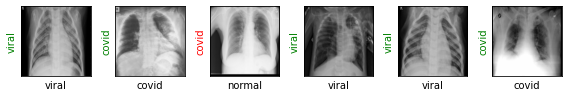

Evaluating at step 20
Validation Loss: 0.3117, Accuracy: 0.9121


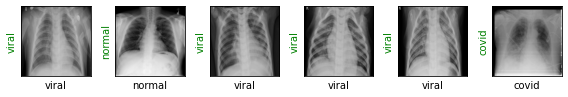

Evaluating at step 40
Validation Loss: 0.2886, Accuracy: 0.8901


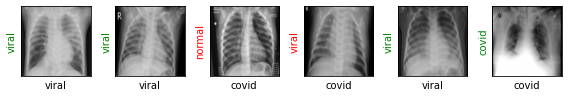

Training Loss: 0.3003
Starting epoch 3/5
Evaluating at step 0
Validation Loss: 0.3969, Accuracy: 0.8571


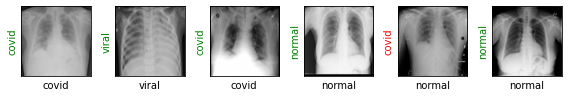

Evaluating at step 20
Validation Loss: 0.2131, Accuracy: 0.9341


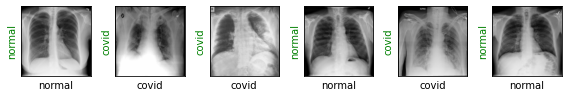

Evaluating at step 40
Validation Loss: 0.2311, Accuracy: 0.9560


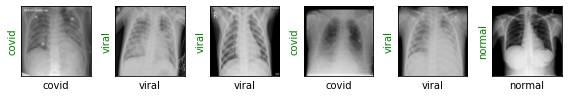

Performance condition satisfied, stopping..
CPU times: user 4min 46s, sys: 7.02 s, total: 4min 53s
Wall time: 2min 42s


In [155]:
%%time

train(epochs=5)

In [156]:
torch.save(resnet18,'./model.pth')

# Final Results

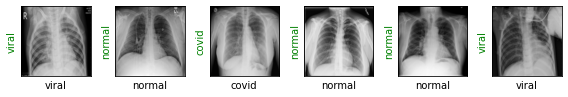

In [157]:
show_preds()
# D_value

In [176]:
# Code below will load Patient image folder from s3 bucket to SageMaker instance;
# Download the images and patient info from S3 to Sagemaker

import boto3 
import os
from botocore.exceptions import ClientError # Not necessary

# Remember to enter the cirrect bucket region below
s3 = boto3.resource('s3', region_name='us-west-2') 
# Replace the place holder with your correct bucket name
bucket = s3.Bucket('covid-19-predict') 

# To Pick Specific image in the bucket
for obj in bucket.objects.filter(Prefix='Predict/X-Ray-Image.png'):
    key = obj.key
    print(key)    
    if not os.path.exists(os.path.dirname(key)):           
        os.makedirs(os.path.dirname(key))

# exception handling  
    try:         
        bucket.download_file(key, key)     
    except ClientError as e:         
        if e.response['Error']['Code'] == "404":             
            print("No object with this key.")        
        else:             
            raise
            
# To Pick patient info document from the bucket
for obj in bucket.objects.filter(Prefix='Predict/Result.docx'):
    key = obj.key
    print(key)    
    if not os.path.exists(os.path.dirname(key)):           
        os.makedirs(os.path.dirname(key))

# exception handling
    try:         
        bucket.download_file(key, key)     
    except ClientError as e:         
        if e.response['Error']['Code'] == "404":             
            print("No object with this key.")        
        else:             
            raise

Predict/X-Ray-Image.png
Predict/Result.docx


In [177]:
model = torch.load('./model.pth')
model.eval()
loader = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean =[0.485,0.456,0.406],std=[0.229,0.224,0.225]),    
])
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert('RGB')
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image
#pass the path of the image to be tested
image = image_loader('Predict/X-Ray-Image.png')
global resdict
res_dict = {0:"Covid Positive",1:"Covid Negative",2:"Viral Pneumonia"}
output = model(image)
# print(output)
_, preds = torch.max(output, 1)
# print(preds)
resdict = (res_dict[preds.tolist()[0]])

In [178]:
print(resdict)

Covid Positive


In [179]:
# Upload the image to S3 bucket

out_bucket = 'covid-19-output'

boto3.Session().resource('s3').Bucket(out_bucket).Object(os.path.join('predicted', 'X-Ray-Image.png')).upload_file('Predict/X-Ray-Image.png')

In [180]:
# Concate today's date to Test Result to save in S3

import datetime
current_date = datetime.date.today()
global DTE
DTE = "DATE : " + str(current_date)
global TResult 
TResult = "Patient Test Result : " + str(resdict)


In [181]:
# pip install python-docx

In [182]:
# Update the Result to the Docx

import docx

mydoc = docx.Document('Predict/Result.docx')

mydoc.add_paragraph(DTE)
mydoc.add_paragraph("")
mydoc.add_paragraph(TResult)
mydoc.add_paragraph("")
mydoc.add_paragraph("Chest X-Ray Image")
mydoc.add_picture("Predict/X-Ray-Image.png", width=docx.shared.Inches(2), height=docx.shared.Inches(2))

mydoc.save('Predict/Result.docx')

# Save Result docx into S3 bucket

bucket_name = 'covid-19-output'
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join('predicted', 'Result.docx')).upload_file('Predict/Result.docx')

In [183]:
print(stopper) # DUMMY STEP

NameError: name 'stopper' is not defined

In [ ]:
# Delete Patient old Record before next Run

os.remove("Predict/Result.docx")

In [ ]:
os.remove("Predict/X-Ray-Image.png")